# CESM-LE biomass

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')

### Get the CESM-LE variables (annual means calculated in cesm-le-ann_means_alldepths.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC','spC','zooC','Fe_150m','PAR_avg']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_ens_mean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC
spC
zooC
Fe_150m
PAR_avg
CPU times: user 265 ms, sys: 26.9 ms, total: 292 ms
Wall time: 628 ms


In [3]:
ds['spC_zint'] = (ds.spC * 10.).sum(dim='z_t_150m')
ds['diatC_zint'] = (ds.diatC * 10.).sum(dim='z_t_150m')
ds['zooC_zint'] = (ds.zooC * 10.).sum(dim='z_t_150m')




In [4]:
ds['mesozooC'] = ds.zooC * (ds.diatC/(ds.diatC + ds.spC))
ds['diat_frac'] = ds.diatC/(ds.diatC + ds.spC)
ds['diat_frac_zint'] = ds.diatC_zint/(ds.diatC_zint + ds.spC_zint)

In [5]:
variables = variables + ['mesozooC','diat_frac','diat_frac_zint']

### Necessary plotting function

In [6]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### get pop grid

In [7]:
grid = pop_tools.get_grid('POP_gx1v6')

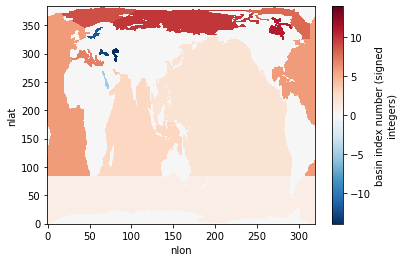

In [8]:
grid.REGION_MASK.plot()

In [9]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA
depths_m = np.arange(5,155,10)
years = ds.time.values

In [10]:
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, nreg: 14, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Caspian Sea' 'Black Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -14 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v6/grid/topography_20090204.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4
    type:               dipole
    title:              POP_gx1v6 grid

In [11]:
depths_m = grid.z_t.isel(z_t=slice(0,15)) * 0.01
depths_m.values

array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
       115., 125., 135., 145.])

### mask out nans in ds

In [12]:
ds = ds.where(grid.REGION_MASK>0)

### ACC and SIZ masks: get them

In [13]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320)
Coordinates:
    TLAT      (nlat, nlon) float64 ...
    TLONG     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask  (nlat, nlon) float64 ...
    SIZ_mask  (nlat, nlon) float64 ...

In [14]:
PAR_change = ds.PAR_avg.isel(time=slice(-11,-1)).mean(dim='time') - ds.PAR_avg.isel(time=slice(0,9)).mean(dim='time')

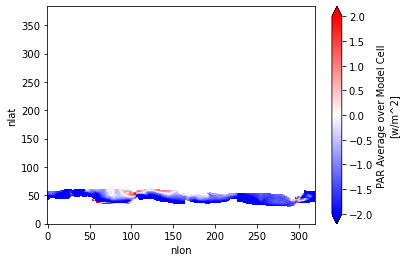

In [15]:
PAR_change.isel(z_t_150m=0).where(ds_masks.ACC_mask==1).plot(vmin=-2,vmax=2,cmap='bwr')

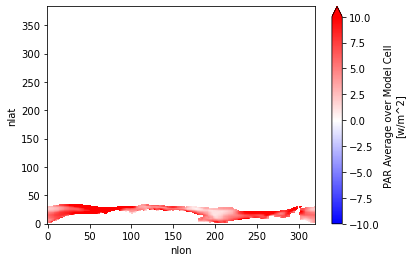

In [16]:
PAR_change.isel(z_t_150m=0).where(ds_masks.SIZ_mask==1).plot(vmin=-10,vmax=10,cmap='bwr')

In [17]:
Fe_change = ds.Fe_150m.isel(time=slice(-11,-1)).mean(dim='time') - ds.Fe_150m.isel(time=slice(0,9)).mean(dim='time')

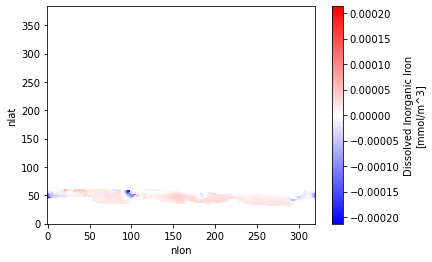

In [18]:
Fe_change.isel(z_t_150m=0).where(ds_masks.ACC_mask==1).plot(cmap='bwr')

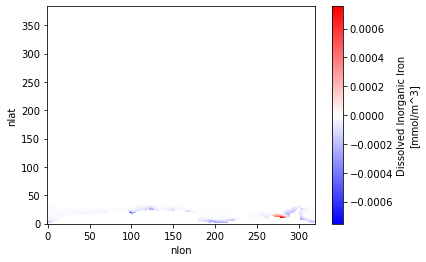

In [19]:
Fe_change.isel(z_t_150m=0).where(ds_masks.SIZ_mask==1).plot(cmap='bwr')

### extract 1920s

In [20]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [21]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### extract 1990s

In [22]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [23]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [24]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [25]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

### make profiles for each decade for Southern Ocean ACC and SIZ

In [26]:
profiles_ACC_1920s = xr.Dataset({v: ds[v] for v in ['z_t_150m']})
profiles_SIZ_1920s = xr.Dataset({v: ds[v] for v in ['z_t_150m']})

for var in variables:
    masked = ds_1920s[var].where(ds_masks.ACC_mask==1)
    profiles_ACC_1920s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_1920s[var].where(ds_masks.SIZ_mask==1)
    profiles_SIZ_1920s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

In [27]:
profiles_ACC_1990s = xr.Dataset({v: ds[v] for v in ['z_t_150m']})
profiles_SIZ_1990s = xr.Dataset({v: ds[v] for v in ['z_t_150m']})

for var in variables:
    masked = ds_1990s[var].where(ds_masks.ACC_mask==1)
    profiles_ACC_1990s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_1990s[var].where(ds_masks.SIZ_mask==1)
    profiles_SIZ_1990s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

In [28]:
profiles_ACC_2090s = xr.Dataset({v: ds[v] for v in ['z_t_150m']})
profiles_SIZ_2090s = xr.Dataset({v: ds[v] for v in ['z_t_150m']})

for var in variables:
    masked = ds_2090s[var].where(ds_masks.ACC_mask==1)
    profiles_ACC_2090s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_2090s[var].where(ds_masks.SIZ_mask==1)
    profiles_SIZ_2090s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

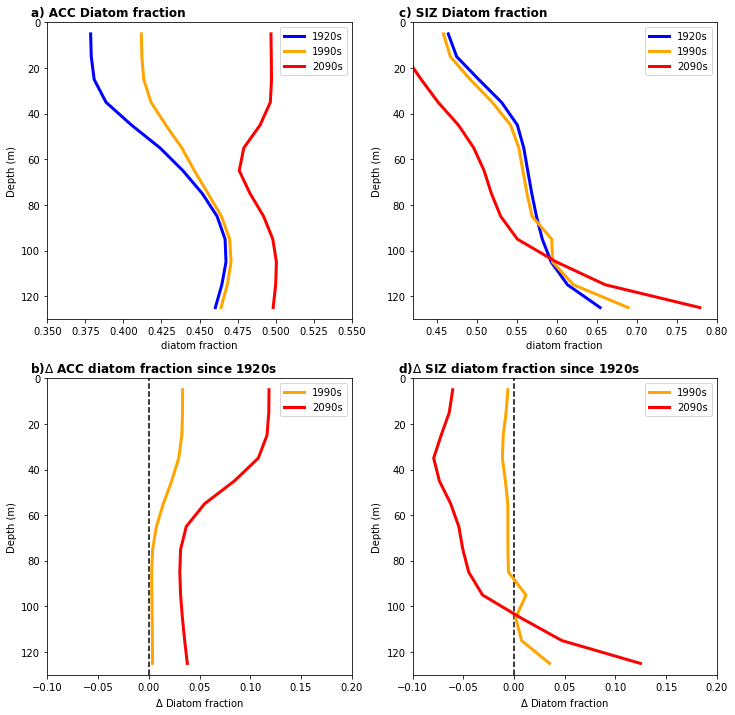

In [29]:
fig = plt.figure(figsize=(12,12))

######################### ACC

### diat frac
ax = fig.add_subplot(2,2,1)
ax.set_title('a) ACC Diatom fraction', x=0.2,fontweight='bold')
ax.set_ylim(0,130)
ax.set_xlim(0.35,0.55)
ax.plot(profiles_ACC_1920s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1920s', linewidth=3,color='blue')
ax.plot(profiles_ACC_1990s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_ACC_2090s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='diatom fraction') #'NO$_3$ (mmol m$^{-3}$)')
ax.invert_yaxis()

### diat frac diff from 1920s
ax = fig.add_subplot(2,2,3)
ax.set_ylim(0,130)
ax.set_xlim(-0.1,0.2)
plt.axvline(x=0,color='black',linestyle='--')
ax.set_title('b)${\Delta}$ ACC diatom fraction since 1920s', x=0.35,fontweight='bold')
ax.plot(profiles_ACC_1990s['diat_frac'].isel(z_t_150m=slice(0,13))-profiles_ACC_1920s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_ACC_2090s['diat_frac'].isel(z_t_150m=slice(0,13))-profiles_ACC_1920s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='${\Delta}$ Diatom fraction') #'NO$_3$ (mmol m$^{-3}$)')
ax.invert_yaxis()

######################### SIZ


### diat frac
ax = fig.add_subplot(2,2,2)
ax.set_title('c) SIZ Diatom fraction', x=0.2,fontweight='bold')
ax.set_ylim(0,130)
ax.set_xlim(0.42,0.8)
ax.plot(profiles_SIZ_1920s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1920s', linewidth=3,color='blue')
ax.plot(profiles_SIZ_1990s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_SIZ_2090s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='diatom fraction') #'NO$_3$ (mmol m$^{-3}$)')
ax.invert_yaxis()

### diat frac diff from 1920s
ax = fig.add_subplot(2,2,4)
ax.set_ylim(0,130)
ax.set_xlim(-0.1,0.2)
plt.axvline(x=0,color='black',linestyle='--')
ax.set_title('d)${\Delta}$ SIZ diatom fraction since 1920s', x=0.35,fontweight='bold')
ax.plot(profiles_SIZ_1990s['diat_frac'].isel(z_t_150m=slice(0,13))-profiles_SIZ_1920s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_SIZ_2090s['diat_frac'].isel(z_t_150m=slice(0,13))-profiles_SIZ_1920s['diat_frac'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='${\Delta}$ Diatom fraction') #'NO$_3$ (mmol m$^{-3}$)')
ax.invert_yaxis()

### Fe profiles

In [30]:
convert = 1000. #for converting mmol to nmol

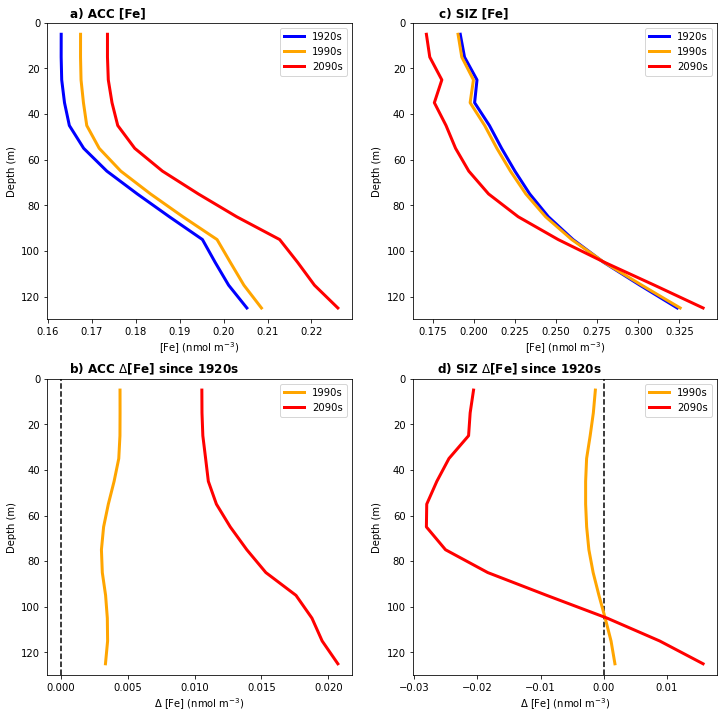

In [31]:
fig = plt.figure(figsize=(12,12))

######################### ACC

### diat frac
ax = fig.add_subplot(2,2,1)
ax.set_title('a) ACC [Fe]', x=0.2,fontweight='bold')
ax.set_ylim(0,130)
#ax.set_xlim(0.35,0.55)
ax.plot(profiles_ACC_1920s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='1920s', linewidth=3,color='blue')
ax.plot(profiles_ACC_1990s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_ACC_2090s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='[Fe] (nmol m$^{-3}$)') #'NO$_3$ (mmol m$^{-3}$)')
ax.invert_yaxis()

### diat frac diff from 1920s
ax = fig.add_subplot(2,2,3)
ax.set_ylim(0,130)
#ax.set_xlim(-0.1,0.2)
plt.axvline(x=0,color='black',linestyle='--')
ax.set_title('b) ACC ${\Delta}$[Fe] since 1920s', x=0.35,fontweight='bold')
ax.plot(profiles_ACC_1990s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert-profiles_ACC_1920s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_ACC_2090s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert-profiles_ACC_1920s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='${\Delta}$ [Fe] (nmol m$^{-3}$)') #'NO$_3$ (mmol m$^{-3}$)')
ax.invert_yaxis()

######################### SIZ


### diat frac
ax = fig.add_subplot(2,2,2)
ax.set_title('c) SIZ [Fe]', x=0.2,fontweight='bold')
ax.set_ylim(0,130)
#ax.set_xlim(0.42,0.8)
ax.plot(profiles_SIZ_1920s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='1920s', linewidth=3,color='blue')
ax.plot(profiles_SIZ_1990s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_SIZ_2090s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='[Fe] (nmol m$^{-3}$)')
ax.invert_yaxis()

### diat frac diff from 1920s
ax = fig.add_subplot(2,2,4)
ax.set_ylim(0,130)
#ax.set_xlim(-0.1,0.2)
plt.axvline(x=0,color='black',linestyle='--')
ax.set_title('d) SIZ ${\Delta}$[Fe] since 1920s', x=0.35,fontweight='bold')
ax.plot(profiles_SIZ_1990s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert-profiles_SIZ_1920s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_SIZ_2090s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert-profiles_SIZ_1920s['Fe_150m'].isel(z_t_150m=slice(0,13))* convert,
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='${\Delta}$ [Fe] (nmol m$^{-3}$)') #'NO$_3$ (mmol m$^{-3}$)')
ax.invert_yaxis()

### PAR profiles

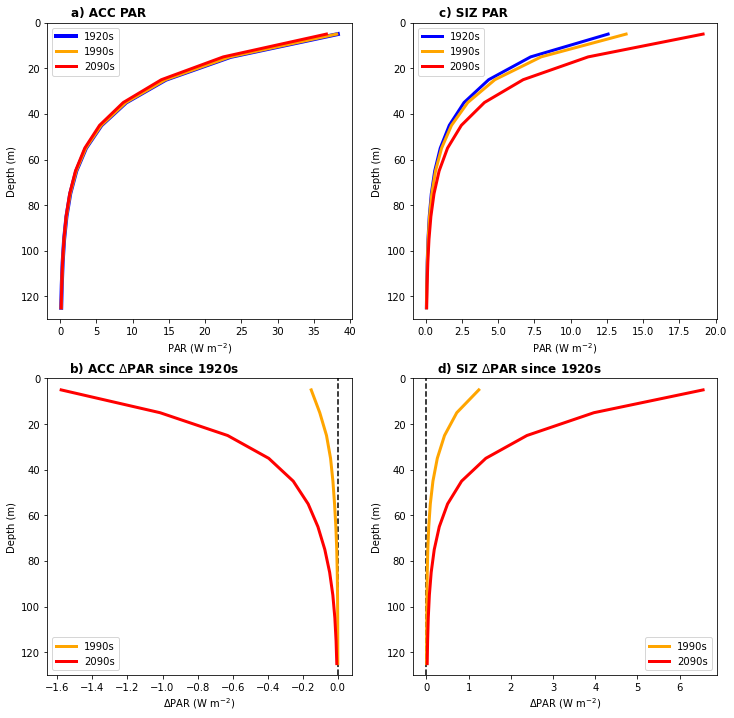

In [32]:
fig = plt.figure(figsize=(12,12))

######################### ACC

### diat frac
ax = fig.add_subplot(2,2,1)
ax.set_title('a) ACC PAR', x=0.2,fontweight='bold')
ax.set_ylim(0,130)
#ax.set_xlim(0.35,0.55)
ax.plot(profiles_ACC_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1920s', linewidth=4,color='blue')
ax.plot(profiles_ACC_1990s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_ACC_2090s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='PAR (W m$^{-2}$)')
ax.invert_yaxis()

### diat frac diff from 1920s
ax = fig.add_subplot(2,2,3)
ax.set_ylim(0,130)
#ax.set_xlim(-0.1,0.2)
plt.axvline(x=0,color='black',linestyle='--')
ax.set_title('b) ACC ${\Delta}$PAR since 1920s', x=0.35,fontweight='bold')
ax.plot(profiles_ACC_1990s['PAR_avg'].isel(z_t_150m=slice(0,13))-profiles_ACC_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_ACC_2090s['PAR_avg'].isel(z_t_150m=slice(0,13))-profiles_ACC_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='${\Delta}$PAR (W m$^{-2}$)')
ax.invert_yaxis()

######################### SIZ


### diat frac
ax = fig.add_subplot(2,2,2)
ax.set_title('c) SIZ PAR', x=0.2,fontweight='bold')
ax.set_ylim(0,130)
#ax.set_xlim(0.42,0.8)
ax.plot(profiles_SIZ_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1920s', linewidth=3,color='blue')
ax.plot(profiles_SIZ_1990s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_SIZ_2090s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='PAR (W m$^{-2}$)')
ax.invert_yaxis()

### diat frac diff from 1920s
ax = fig.add_subplot(2,2,4)
ax.set_ylim(0,130)
#ax.set_xlim(-0.1,0.2)
plt.axvline(x=0,color='black',linestyle='--')
ax.set_title('d) SIZ ${\Delta}$PAR since 1920s', x=0.35,fontweight='bold')
ax.plot(profiles_SIZ_1990s['PAR_avg'].isel(z_t_150m=slice(0,13))-profiles_SIZ_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_SIZ_2090s['PAR_avg'].isel(z_t_150m=slice(0,13))-profiles_SIZ_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='${\Delta}$PAR (W m$^{-2}$)')
ax.invert_yaxis()

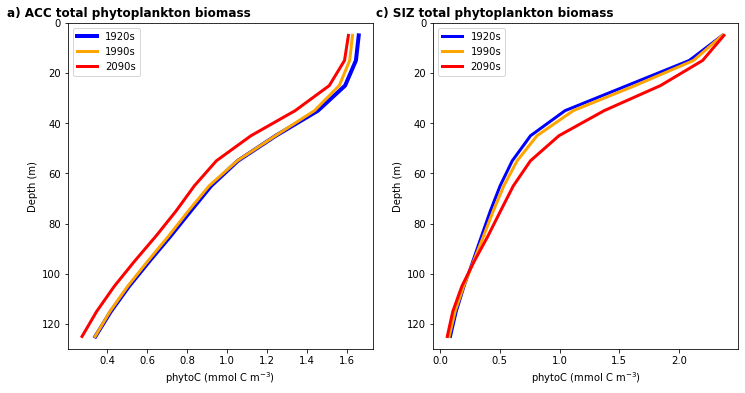

In [49]:
fig = plt.figure(figsize=(12,6))

######################### ACC

### diat frac
ax = fig.add_subplot(1,2,1)
ax.set_title('a) ACC total phytoplankton biomass', x=0.2,fontweight='bold')
ax.set_ylim(0,130)
#ax.set_xlim(0.35,0.55)
ax.plot(profiles_ACC_1920s['spC'].isel(z_t_150m=slice(0,13))+profiles_ACC_1920s['diatC'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1920s', linewidth=4,color='blue')
ax.plot(profiles_ACC_1990s['spC'].isel(z_t_150m=slice(0,13))+profiles_ACC_1990s['diatC'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_ACC_2090s['spC'].isel(z_t_150m=slice(0,13))+profiles_ACC_2090s['diatC'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='phytoC (mmol C m$^{-3}$)')
ax.invert_yaxis()

# ### diat frac diff from 1920s
# ax = fig.add_subplot(2,2,3)
# ax.set_ylim(0,130)
# #ax.set_xlim(-0.1,0.2)
# plt.axvline(x=0,color='black',linestyle='--')
# ax.set_title('b) ACC ${\Delta}$PAR since 1920s', x=0.35,fontweight='bold')
# ax.plot(profiles_ACC_1990s['PAR_avg'].isel(z_t_150m=slice(0,13))-profiles_ACC_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
#         depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
# ax.plot(profiles_ACC_2090s['PAR_avg'].isel(z_t_150m=slice(0,13))-profiles_ACC_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
#         depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
# ax.legend()
# ax.set(ylabel='Depth (m)',xlabel='${\Delta}$PAR (W m$^{-2}$)')
# ax.invert_yaxis()

######################### SIZ


### diat frac
ax = fig.add_subplot(1,2,2)
ax.set_title('c) SIZ total phytoplankton biomass', x=0.2,fontweight='bold')
ax.set_ylim(0,130)
#ax.set_xlim(0.42,0.8)
ax.plot(profiles_SIZ_1920s['spC'].isel(z_t_150m=slice(0,13))+profiles_SIZ_1920s['diatC'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1920s', linewidth=3,color='blue')
ax.plot(profiles_SIZ_1990s['spC'].isel(z_t_150m=slice(0,13))+profiles_SIZ_1990s['diatC'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
ax.plot(profiles_SIZ_2090s['spC'].isel(z_t_150m=slice(0,13))+profiles_SIZ_2090s['diatC'].isel(z_t_150m=slice(0,13)),
        depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='phytoC (mmol C m$^{-3}$)')
ax.invert_yaxis()

# ### diat frac diff from 1920s
# ax = fig.add_subplot(2,2,4)
# ax.set_ylim(0,130)
# #ax.set_xlim(-0.1,0.2)
# plt.axvline(x=0,color='black',linestyle='--')
# ax.set_title('d) SIZ ${\Delta}$PAR since 1920s', x=0.35,fontweight='bold')
# ax.plot(profiles_SIZ_1990s['PAR_avg'].isel(z_t_150m=slice(0,13))-profiles_SIZ_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
#         depths_m.isel(z_t=slice(0,13)),  label='1990s', linewidth=3,color='orange')
# ax.plot(profiles_SIZ_2090s['PAR_avg'].isel(z_t_150m=slice(0,13))-profiles_SIZ_1920s['PAR_avg'].isel(z_t_150m=slice(0,13)),
#         depths_m.isel(z_t=slice(0,13)),  label='2090s', linewidth=3,color='red')
# ax.legend()
# ax.set(ylabel='Depth (m)',xlabel='${\Delta}$PAR (W m$^{-2}$)')
# ax.invert_yaxis()

In [34]:
profiles_SIZ_1920s_50m_means = profiles_SIZ_1920s.isel(z_t_150m=slice(0,5)).mean()
profiles_SIZ_1990s_50m_means = profiles_SIZ_1990s.isel(z_t_150m=slice(0,5)).mean()
profiles_SIZ_2090s_50m_means = profiles_SIZ_2090s.isel(z_t_150m=slice(0,5)).mean()

In [35]:
profiles_ACC_1920s_50m_means = profiles_ACC_1920s.isel(z_t_150m=slice(0,5)).mean()
profiles_ACC_1990s_50m_means = profiles_ACC_1990s.isel(z_t_150m=slice(0,5)).mean()
profiles_ACC_2090s_50m_means = profiles_ACC_2090s.isel(z_t_150m=slice(0,5)).mean()

In [36]:
profiles_ACC_1920s_50m_means.PAR_avg

<xarray.DataArray 'PAR_avg' ()>
array(18.25073194)
Attributes:
    long_name:     PAR Average over Model Cell
    units:         w/m^2
    grid_loc:      3114
    cell_methods:  time: mean

In [37]:
profiles_ACC_1990s_50m_means.PAR_avg

<xarray.DataArray 'PAR_avg' ()>
array(18.17280608)
Attributes:
    long_name:     PAR Average over Model Cell
    units:         w/m^2
    grid_loc:      3114
    cell_methods:  time: mean

In [38]:
profiles_ACC_2090s_50m_means.PAR_avg

<xarray.DataArray 'PAR_avg' ()>
array(17.47677628)
Attributes:
    long_name:     PAR Average over Model Cell
    units:         w/m^2
    grid_loc:      3114
    cell_methods:  time: mean

In [39]:
profiles_ACC_1920s_50m_means.Fe_150m

<xarray.DataArray 'Fe_150m' ()>
array(0.00016357)
Attributes:
    long_name:     Dissolved Inorganic Iron
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [40]:
profiles_ACC_1990s_50m_means.Fe_150m

<xarray.DataArray 'Fe_150m' ()>
array(0.00016786)
Attributes:
    long_name:     Dissolved Inorganic Iron
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [41]:
profiles_ACC_2090s_50m_means.Fe_150m

<xarray.DataArray 'Fe_150m' ()>
array(0.00017427)
Attributes:
    long_name:     Dissolved Inorganic Iron
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [42]:
profiles_SIZ_1920s_50m_means.PAR_avg

<xarray.DataArray 'PAR_avg' ()>
array(5.6825526)
Attributes:
    long_name:     PAR Average over Model Cell
    units:         w/m^2
    grid_loc:      3114
    cell_methods:  time: mean

In [43]:
profiles_SIZ_1990s_50m_means.PAR_avg

<xarray.DataArray 'PAR_avg' ()>
array(6.24316415)
Attributes:
    long_name:     PAR Average over Model Cell
    units:         w/m^2
    grid_loc:      3114
    cell_methods:  time: mean

In [44]:
profiles_SIZ_2090s_50m_means.PAR_avg

<xarray.DataArray 'PAR_avg' ()>
array(8.71126084)
Attributes:
    long_name:     PAR Average over Model Cell
    units:         w/m^2
    grid_loc:      3114
    cell_methods:  time: mean

In [45]:
profiles_SIZ_1920s_50m_means.Fe_150m

<xarray.DataArray 'Fe_150m' ()>
array(0.00019948)
Attributes:
    long_name:     Dissolved Inorganic Iron
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [46]:
profiles_SIZ_1990s_50m_means.Fe_150m

<xarray.DataArray 'Fe_150m' ()>
array(0.00019733)
Attributes:
    long_name:     Dissolved Inorganic Iron
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [47]:
profiles_SIZ_2090s_50m_means.Fe_150m

<xarray.DataArray 'Fe_150m' ()>
array(0.00017666)
Attributes:
    long_name:     Dissolved Inorganic Iron
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean